# Human Action Recognition

## Import All Library

In [ ]:
%%capture
!pip install pafy youtube-dl moviepy
# this librearies helps to download the youtube video

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout,Flatten,Dense

  if event.key is 'enter':



In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Download the Data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d pypiahmad/realistic-action-recognition-ucf50

Dataset URL: https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.04G/3.04G [01:36<00:00, 41.9MB/s]
100% 3.04G/3.04G [01:36<00:00, 33.9MB/s]


In [ ]:
import zipfile
import os
# Replace 'your_file.zar' with the actual file name
file_path = '/content/realistic-action-recognition-ucf50.zip'
extract_path = '/content/all_data_file'

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the .zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Visualization The Data

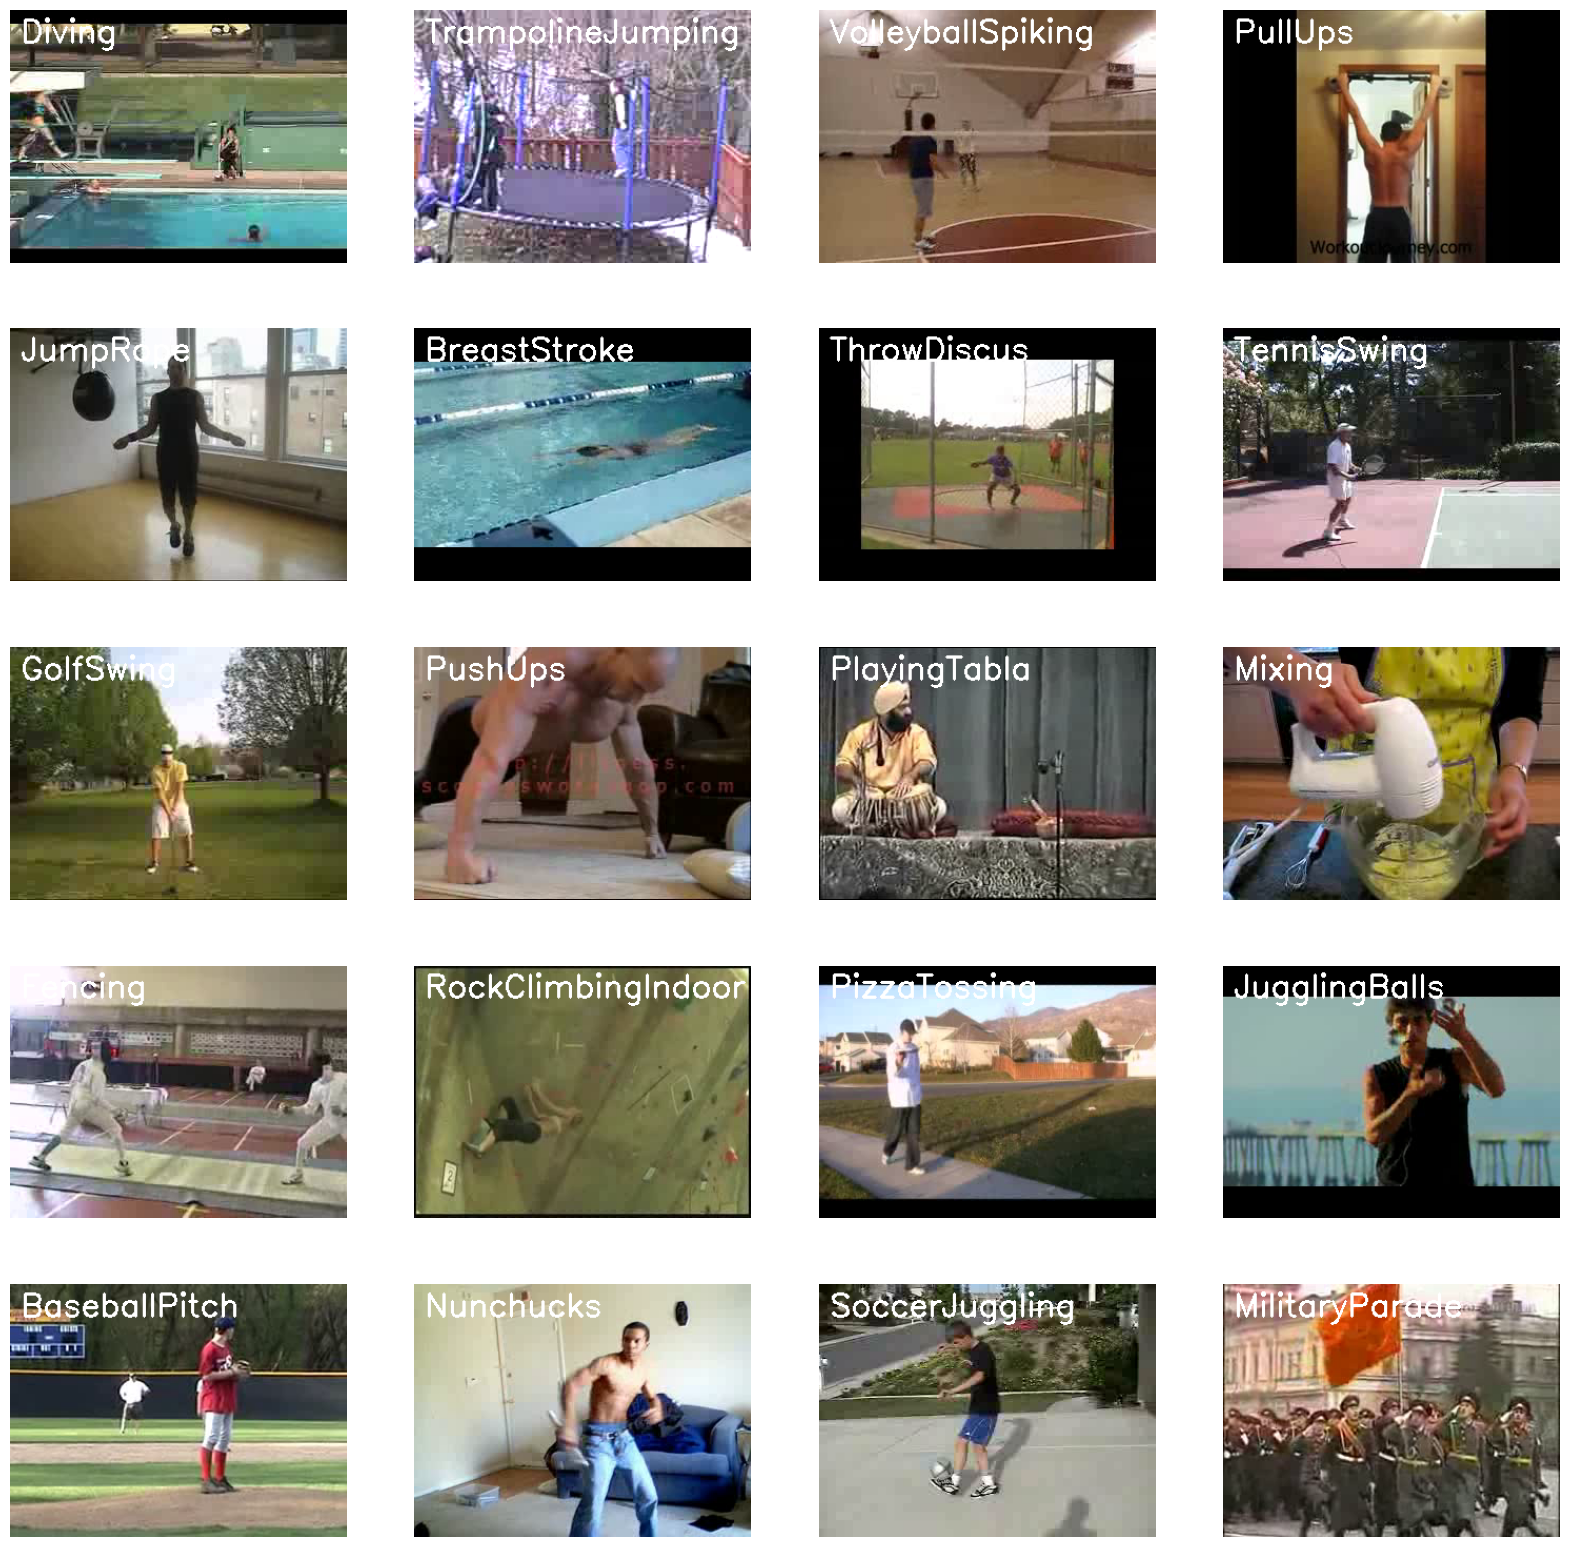

In [ ]:
plt.figure(figsize=(20,20))
all_class_names=os.listdir('/content/all_data_file/UCF50')
random_range=random.sample(range(len(all_class_names)),20)

for counter,random_index in enumerate(random_range,1):
   selected_class_names=all_class_names[random_index]
   video_files_names_list=os.listdir(f'/content/all_data_file/UCF50/{selected_class_names}')
   selected_video_file_name=random.choice(video_files_names_list)
   video_reader=cv2.VideoCapture(f'/content/all_data_file/UCF50/{selected_class_names}/{selected_video_file_name}')
   _,bgr_frame=video_reader.read()
   video_reader.release()
   rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
   cv2.putText(rgb_frame,selected_class_names,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
   plt.subplot(5,4,counter)
   plt.imshow(rgb_frame)
   plt.axis('off')


# Pre Process The Data

In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH=64,64
SEQUENCE_LENGTH=20
DATASET_DIR='/content/all_data_file/UCF50'
CLASSES_LIST=['Basketball','Biking','Diving','WalkingWithDog','PullUps','Swing','PushUps','HighJump','PlayingGuitar']

In [ ]:
def frame_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
  features=[]
  labels=[]
  video_file_paths=[]
  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'extracting data of class:{class_name}')
    file_list=os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in file_list:
      video_file_path=os.path.join(DATASET_DIR,class_name,file_name)
      frames=frame_extraction(video_file_path)
      if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_file_path)
  features=np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_file_path

# Create the Dataset

In [ ]:
features,labels,video_file_path=create_dataset()

extracting data of class:Basketball
extracting data of class:Biking
extracting data of class:Diving
extracting data of class:WalkingWithDog
extracting data of class:PullUps
extracting data of class:Swing
extracting data of class:PushUps
extracting data of class:HighJump
extracting data of class:PlayingGuitar


In [ ]:
features.shape

(1204, 20, 64, 64, 3)

In [ ]:
one_hot_encoded_labels=to_categorical(labels)

# Train Test Split The Data

In [ ]:
from sklearn.model_selection import train_test_split
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,
                                                                       test_size=0.25,
                                                                       shuffle=True,
                                                                       random_state=seed_constant)

# --- Implement The ConvLSTM Approach ---

In [ ]:
def create_covlstm_model():
  model=Sequential()

  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True,input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST),activation="softmax"))

  model.summary()

  return model

In [32]:
convlstm_model=create_covlstm_model()
print('\n Moddel created succesfully')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │          25,929 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,929 (230.19 KB)

 Trainable params: 58,929 (230.19 KB)

 Non-trainable params: 0 (0.00 B)


 Moddel created succesfully


# Compile & Train The Model

In [38]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history=convlstm_model.fit(x=features_train,y=labels_train,epochs=50,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.0826 - loss: 2.1975 - val_accuracy: 0.0884 - val_loss: 2.1988
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.1688 - loss: 2.1447 - val_accuracy: 0.2155 - val_loss: 2.0345
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.2614 - loss: 1.9619 - val_accuracy: 0.2320 - val_loss: 1.9838
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3388 - loss: 1.7580 - val_accuracy: 0.3260 - val_loss: 1.7849
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4623 - loss: 1.5035 - val_accuracy: 0.3149 - val_loss: 1.8324
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.5189 - loss: 1.3604 - val_accuracy: 0.3867 - val_loss: 1.8486
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6026 - loss: 1.1712 - val_accuracy: 0.4309 - val_loss: 1.6229
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.6583 - loss: 1.0072 - val_accuracy: 0.

# Evalute The Trained Model

In [39]:
model_evaluate_history=convlstm_model.evaluate(features_test,labels_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.6418 - loss: 1.1343


# Plot Model Loss and accuracy curves

In [43]:
model_evalution_loss, model_evalution_accuract = model_evaluate_history

In [69]:
def plot_metric(model_training_history, metric_name1, metric_name2, plot_name):

  metric_value1 = model_training_history.history[metric_name1]
  matric_value2 = model_training_history.history[metric_name2]
  epochs=range(len(metric_value1))

  plt.plot(epochs,metric_value1,'b',label= metric_name1)
  plt.plot(epochs,matric_value2,'r',label= metric_name2)

  plt.title(str(plot_name))
  plt.legend()

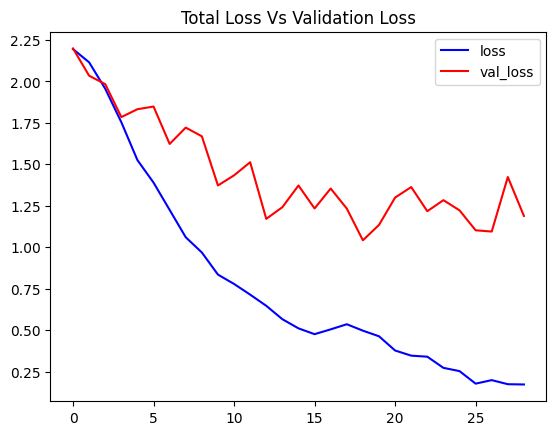

In [70]:
plot_metric(history,'loss','val_loss','Total Loss Vs Validation Loss')

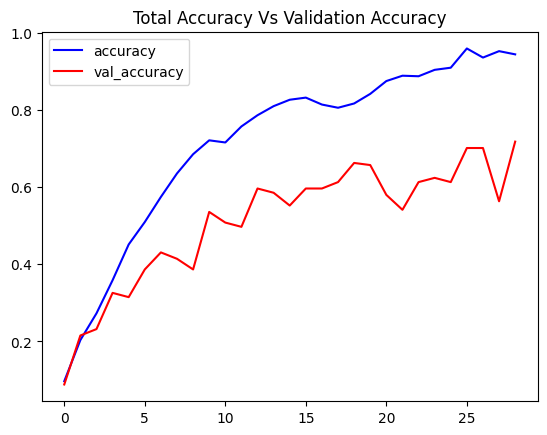

In [71]:
plot_metric(history,'accuracy','val_accuracy','Total Accuracy Vs Validation Accuracy')

# Test Best Performing Model on Youtube Videos

In [ ]:
def download_youtube_videos(youtube_video_url,out_directory):
  video=pafy.new(youtube_video_url)
  title=video.title
  video_best=video.getbest()
  output_file_path=f'{out_directory}/{title}.mp4'
  video_best.download(filepath=output_file_path,quiet=True)
  return title

In [ ]:
def frame_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

# Perform The Prediction

In [73]:
features=[]
video_file_path='/content/v_Biking_g01_c02.avi'
frames=frame_extraction(video_file_path)
if len(frames)==SEQUENCE_LENGTH:
        features.append(frames)
features=np.asarray(features)
predicted_label_probabilities=convlstm_model.predict(features)[0]
predicted_label=np.argmax(predicted_label_probabilities)
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1


# Save The Model

In [76]:
convlstm_model.save('/content/model_saved_file/human_action_recognition.h5')